# Data Pipeline - Celebrities Dataset

Dataset of 202,599 face images available at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

Images are not the same size or resolution. This file converts all images in a standard format: 64*64 px


__WARNING:__ This dataset is pretty big to be loaded in a Notebook, so it is best to proceed by __batches__ for the preprocesing

In [20]:
# Modify to run on your local machine

faces_path = "/Users/Clement/Desktop/CS282_ImageInpainting/datasets/img_align_celeba/"
faces_prep_path = "/Users/Clement/Desktop/CS282_ImageInpainting/datasets/faces_pp/"

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
import csv
import os
from PIL import Image

%matplotlib inline

# Examples

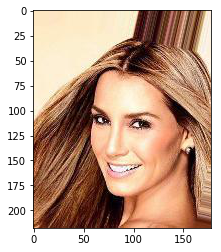

In [22]:
image = Image.open(faces_path + "/000001.jpg")
plt.imshow(image)

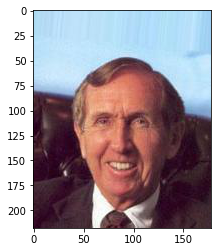

In [23]:
image = Image.open(faces_path + "/000021.jpg")
plt.imshow(image)

In [24]:
## Number of images in the dataset

print(len(os.listdir(faces_path)), "images found")

202599 images found


# Resize Format 

In [25]:
height = width = 64
channels = 3 #RGB

# Load Dataset

#### Open images as Numpy array

In [26]:
batch = 4000 # To limit the amount of data loaded in the notebook 

face_images = os.listdir(faces_path)[:batch]

X_all = np.zeros((len(face_images), height, width, channels))

print("Loading Dataset...")
for i in range(len(face_images)):
    img = Image.open(faces_path + face_images[i])
    try:
        X_all[i] = np.asarray(img.resize((height, width)))
    except:
        # gray scale images cannot be loaded as RGB
        print(face_images[i], "Could not be loaded")
        X_all[i] = X_all[i-1] #just to not have a null image
print("Done!")

Loading Dataset...
Done!


In [27]:
# Sanity check
print("X_all shape:", X_all.shape)

X_all shape: (4000, 64, 64, 3)


#### Reshape to standard format (N, C, H, W) for deep learning models

In [28]:
def reshape_NCHW(X):
    return X.transpose((0, 3, 1, 2))

X_all = reshape_NCHW(X_all)
print("X_all shape:", X_all.shape)

X_all shape: (4000, 3, 64, 64)


#### Standardize images

Set all pixel values between 0 and 1, by dividing by 255 (range of RGB pixel)

In [29]:
def standardize(X):
    return X / 255.

X_all = standardize(X_all)

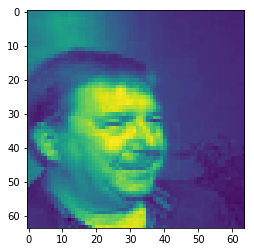

In [30]:
# example
plt.imshow(X_all[888, 0, :, :])

#### Image mask/default generator

Assumption: we impose a mask to be a least 7 in width and 7 in height (except if mask touches the borders)

In [31]:
# save an original X_all dataset
X_original = X_all.copy()

In [32]:
def mask(img, loc):
    """Set to zero all pixels contained in a given location on the image
    
    Input:
    - img: image of shape (C, H, W)
    - loc: location (x, y, h, w)
    """
    x, y, h, w = loc
    h = min(h, height-y)
    w = min(w, width-x)
    img[:, x:x+w, y:y+h] = 0.5

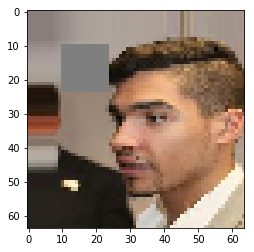

In [33]:
# example 
mask(X_all[16], (10, 10, 14, 14))
plt.imshow(X_all[16].transpose(1, 2, 0))

#### genrate a full dataset of images with random masks

In [34]:
range_x = np.arange(width)
range_y = np.arange(height)
range_h = np.arange(10, 20)
range_w = np.arange(10, 20)

In [35]:
np.random.seed(123)

# Uniform
xs = np.random.choice(range_x, X_all.shape[0]) # upper left corner
ys = np.random.choice(range_y, X_all.shape[0]) # upper left corner
hs = np.random.choice(range_h, X_all.shape[0]) # height
ws = np.random.choice(range_w, X_all.shape[0]) # width

# Gaussian
xg = np.random.normal(25,10,X_all.shape[0]) 
yg = np.random.normal(25,10,X_all.shape[0])

gaussian = True

if gaussian:
    for img, x, y, h, w in zip(X_all, xg.astype(int), yg.astype(int), hs, ws):
        mask(img, (x, y, h, w))
else:
    for img, x, y, h, w in zip(X_all, xs, ys, hs, ws):
        mask(img, (x, y, h, w))

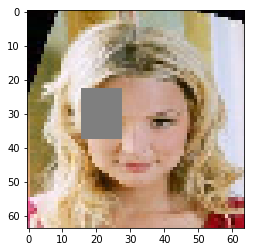

In [36]:
# sanity check
plt.imshow(X_all[124].transpose(1, 2, 0))

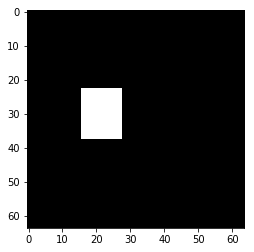

In [37]:
filter_mask = np.zeros(X_all.shape).transpose(0, 2, 3, 1)

for i, x, y, h, w in zip(range(filter_mask.shape[0]), xg.astype(int), yg.astype(int), hs, ws):
    filter_mask[i, x:x+w, y:y+h, :] = 1.
    
plt.imshow(filter_mask[124])

In [60]:
# Save modified dataset (with masks) as pickle file in cars_prep_path directory
with open(faces_prep_path + "faces_masks.pickle", "wb") as file:
    pickle.dump(X_all, file)

In [61]:
# Save original dataset (without masks) as pickle file in cars_prep_path directory
with open(faces_prep_path + "faces_original.pickle", "wb") as file:
    pickle.dump(X_original, file)

In [62]:
# Save mask filters as pickle file in cars_prep_path directory
with open(faces_prep_path + "faces_filter.pickle", "wb") as file:
    pickle.dump(filter_mask, file)

### X_all VS X_original

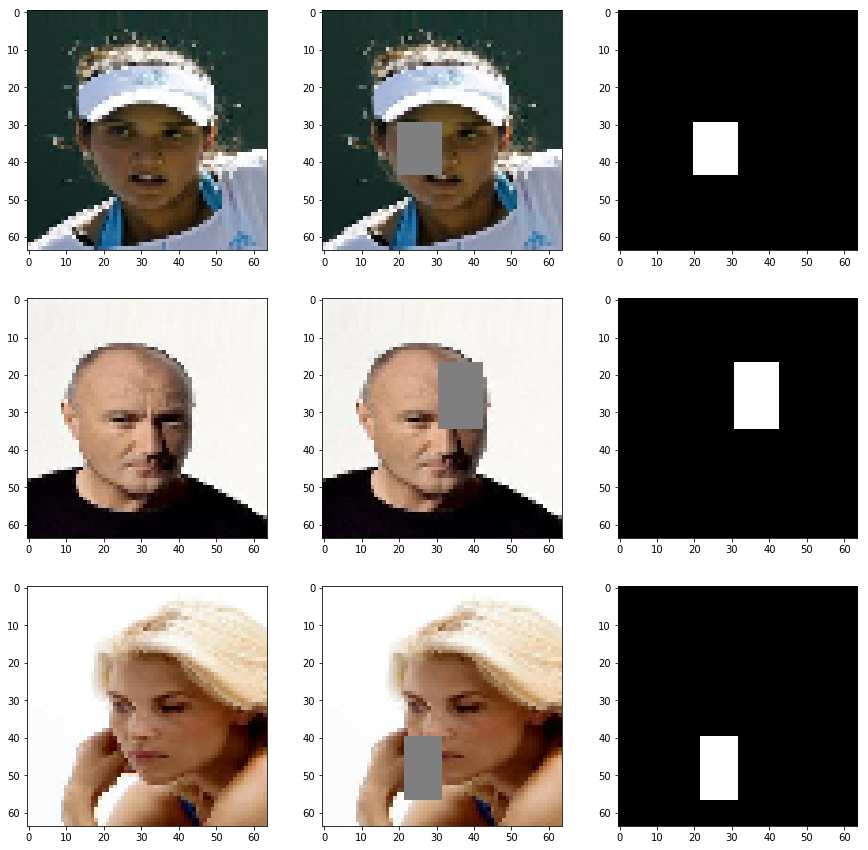

In [64]:
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
plt.imshow(X_original[118].transpose(1, 2, 0))
plt.subplot(3, 3, 2)
plt.imshow(X_all[118].transpose(1, 2, 0))
plt.subplot(3, 3, 3)
plt.imshow(filter_mask[118])
plt.subplot(3, 3, 4)
plt.imshow(X_original[2228].transpose(1, 2, 0))
plt.subplot(3, 3, 5)
plt.imshow(X_all[2228].transpose(1, 2, 0))
plt.subplot(3, 3, 6)
plt.imshow(filter_mask[2228])
plt.subplot(3, 3, 7)
plt.imshow(X_original[231].transpose(1, 2, 0))
plt.subplot(3, 3, 8)
plt.imshow(X_all[231].transpose(1, 2, 0))
plt.subplot(3, 3, 9)
plt.imshow(filter_mask[231])

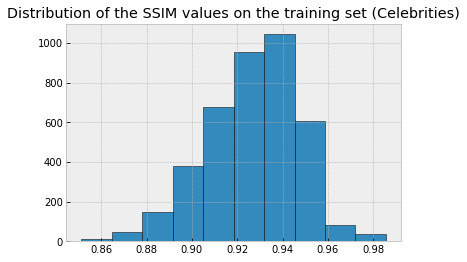

In [43]:
from skimage import measure

s = []
for i in range(len(X_original)):
    s.append(measure.compare_ssim(X_original[i].transpose(1, 2, 0), X_all[i].transpose(1, 2, 0), multichannel=True) * 0.9855820086128981)
with plt.style.context('bmh'):
    plt.hist(s,ec='black')
    plt.title('Distribution of the SSIM values on the training set (Celebrities)')

In [39]:
np.mean(np.array(s))

0.9404507704600338